### IMPORTING PACKAGES

In [2]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


## Loading Data

In [2]:
import os
import pandas as pd

# Read the CSV file
df_train = pd.read_csv('train.csv')

# Print shape and preview the data
print(df_train.shape)
df_train


FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

## EDA

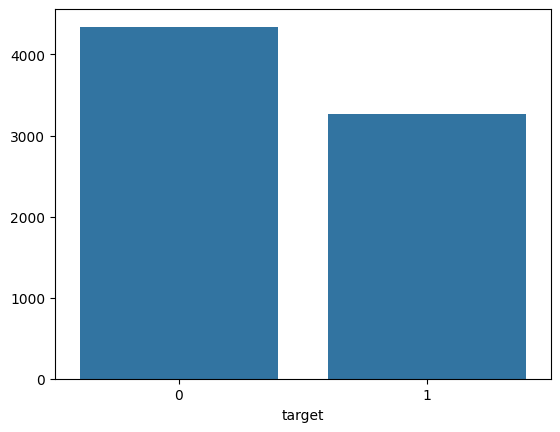

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the values of the 'target' column
x = df_train['target'].value_counts()

# Plot the barplot using the correct arguments
sns.barplot(x=x.index, y=x.values)

# Show the plot
plt.show()


In [5]:
#Missing values
df_train.isna().sum()


,0
id,0
keyword,61
location,2533
text,0
target,0


In [6]:
#1. WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print("Disaster tweets word count:", df_train[df_train['target']==1]['word_count'].mean()) #Disaster tweets
print("Non-disaster tweets word count:", df_train[df_train['target']==0]['word_count'].mean(), "\n") #Non-Disaster tweets
#Disaster tweets are generally more wordy than the non-disaster tweets

#2. CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print("Disaster tweets character count:", df_train[df_train['target']==1]['char_count'].mean()) #Disaster tweets
print("Non-disaster tweets character count:", df_train[df_train['target']==0]['char_count'].mean(), "\n") #Non-Disaster tweets
#Disaster tweets are generally longer than the non-disaster tweets

#3. UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
print("Disaster tweets unique-word count:", df_train[df_train['target']==1]['unique_word_count'].mean()) #Disaster tweets
print("Non-disaster tweets unique-word count:", df_train[df_train['target']==0]['unique_word_count'].mean(), "\n") #Non-Disaster tweets
#Disaster tweets generally have more unique words than the non-disaster tweets


Disaster tweets word count: 15.167532864567411
Non-disaster tweets word count: 14.704744357438969 

Disaster tweets character count: 108.11342097217977
Non-disaster tweets character count: 95.70681713496084 

Disaster tweets unique-word count: 14.664934270865178
Non-disaster tweets unique-word count: 14.09649930907416 



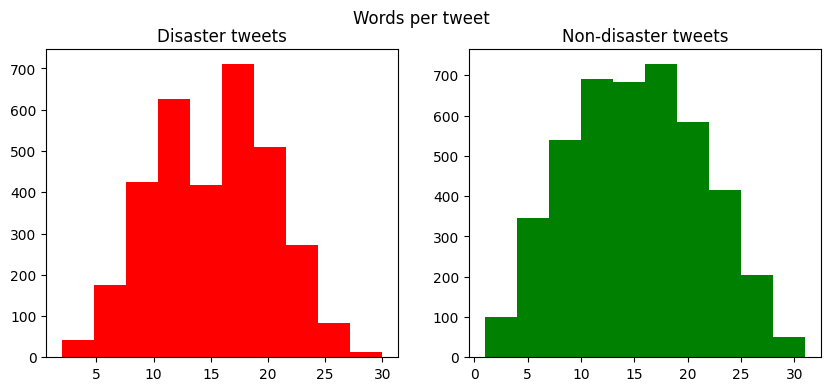

In [7]:
#Plotting word-count per tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']

ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')

train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')

fig.suptitle('Words per tweet')
plt.show()


## PRE-PROCESSING

In [8]:
import re
import string
#1. Common text preprocessing
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  adjacent spaces and tabs     .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text = text.strip()  #get rid of leading/trailing whitespace
    text = re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace

    return text

text = preprocess(text)
print(text)  #text is a string


this is a message to be cleaned it may involve some things like adjacent spaces and tabs


In [12]:
#3. LEXICON-BASED TEXT PROCESSING EXAMPLES

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')


from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

text=stopword(text)
print(text)

#2. STEMMING

# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)
text=stemming(text)
print(text)

#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

text = lemmatizer(text)
print(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...


messag clean may involv thing like adjac space tab
messag clean may involv thing like adjac space tab
messag clean may involv thing like adjac space tab


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [13]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))

# Check if columns exist before dropping
columns_to_drop = ['word_count', 'char_count', 'unique_word_count']
existing_columns = df_train.columns

# Drop only the columns that exist
columns_to_drop = [col for col in columns_to_drop if col in existing_columns]

df_train = df_train.drop(columns=columns_to_drop)
df_train


,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,get sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridge collapse nearby ho...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary thetawniest control wild fire cali...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utc km volcano hawaii http co zdtoyd ebj
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigate e bike collide car little p...


### Word2Vec model

In [14]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


# Use index_to_key instead of index2word and 'vectors' instead of 'syn0'
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


### TRAIN TEST SPLITTING OF LABELLED DATASET

In [15]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION

# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["target"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)


### Building ML models (Text-classification)

#### LR (tf-idf)

In [16]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]


print(classification_report(y_val,y_predict))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_predict))

fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('\nAUC:', roc_auc)


              precision    recall  f1-score   support

           0       0.82      0.80      0.81       883
           1       0.73      0.77      0.75       640

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.78      0.78      1523

Confusion Matrix:
 [[704 179]
 [150 490]]

AUC: 0.860926882785957


#### NB (tf-idf)

In [17]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]


print(classification_report(y_val,y_predict))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_predict))

fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('\nAUC:', roc_auc)


              precision    recall  f1-score   support

           0       0.80      0.90      0.85       883
           1       0.84      0.70      0.76       640

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523

Confusion Matrix:
 [[798  85]
 [194 446]]

AUC: 0.8661717865232164


#### LR (w2v)

In [18]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]


print(classification_report(y_val,y_predict))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_predict))

fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('\nAUC:', roc_auc)


              precision    recall  f1-score   support

           0       0.66      0.81      0.73       883
           1       0.63      0.43      0.51       640

    accuracy                           0.65      1523
   macro avg       0.64      0.62      0.62      1523
weighted avg       0.65      0.65      0.64      1523

Confusion Matrix:
 [[718 165]
 [364 276]]

AUC: 0.6901383776896943


### TESTING THE MODEL ON UNLABELLED DATASET

In [19]:
#Testing it on new dataset with the best model
df_test = pd.read_csv('test.csv')  #reading the data
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x)) #preprocess the data

X_test = df_test['clean_text']
X_vector = tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector) #use the trained model on X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]

df_test['predict_prob'] = y_prob
df_test['target'] = y_predict
print(df_test.head())

final = df_test[['id', 'target', 'predict_prob', 'clean_text']].reset_index(drop=True)
final.to_csv('submission.csv')


   id keyword location                                               text  \
0   0     NaN      NaN                 Just happened a terrible car crash   
1   2     NaN      NaN  Heard about #earthquake is different cities, s...   
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...   
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires   
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan   

                                          clean_text  predict_prob  target  
0                          happen terrible car crash      0.712402       1  
1  heard earthquake different city stay safe ever...      0.864990       1  
2  forest fire spot pond geese flee across street...      0.696796       1  
3                  apocalypse light spokane wildfire      0.843398       1  
4                 typhoon soudelor kill china taiwan      0.994659       1  


In [ ]:
final


,id,target,predict_prob,clean_text
0,0,1,0.849663,happen terrible car crash
1,2,1,0.807369,heard earthquake different city stay safe ever...
2,3,1,0.946176,forest fire spot pond geese flee across street...
3,9,1,0.709425,apocalypse light spokane wildfire
4,11,1,0.993087,typhoon soudelor kill china taiwan
...,...,...,...,...
3258,10861,1,0.634161,earthquake safety los angeles ûò safety fasten...
3259,10865,1,0.733015,storm ri bad last hurricane city amp others ha...
3260,10868,1,0.927370,green line derailment chicago http co utbxlcbiuy
3261,10874,1,0.911945,meg issue hazardous weather outlook hwo http c...


Neural Networks example |
no NLP here


In [20]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Example data: sentences and their respective labels
texts = [
    "This is a positive example",
    "This is a negative example",
    "Another positive case",
    "An example of negative text",
    "Positive case again",
    "Negative situation again",
]
labels = ["positive", "negative", "positive", "negative", "positive", "negative"]

# Encode labels to numerical values
encoder = LabelBinarizer()
labels_encoded = encoder.fit_transform(labels)

# Tokenize the text data
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# Convert text to sequences and pad them
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=10)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels_encoded, test_size=0.2, random_state=42)

# Model configuration
vocab_size = 1000   # Size of the vocabulary (unique words)
embedding_dim = 16  # Dimension of the embedding vector
max_length = 10     # Max length of input sequences (padded to this length)

# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Use softmax if you have more than 2 classes
])

# Compile the model
model.compile(loss='binary_crossentropy',  # 'categorical_crossentropy' for multi-class
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Make predictions
test_text = ["This is a new positive example"]
test_seq = tokenizer.texts_to_sequences(test_text)
test_padded = pad_sequences(test_seq, padding='post', maxlen=max_length)
prediction = model.predict(test_padded)
print(f"Predicted label: {encoder.inverse_transform((prediction > 0.5).astype(int))[0]}")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 312ms/step - accuracy: 0.3333 - loss: 0.6952 - val_accuracy: 1.0000 - val_loss: 0.6925
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5000 - loss: 0.6948 - val_accuracy: 1.0000 - val_loss: 0.6923
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5000 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5000 - loss: 0.6940 - val_accuracy: 1.0000 - val_loss: 0.6918
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5000 - loss: 0.6957 - val_accuracy: 1.0000 - val_loss: 0.6916
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.6904 - val_accuracy: 1.0000 - val_loss: 0.6914
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5000 - loss: 0.6907 - val_accuracy: 0.5000 - val_loss: 0.6912
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8333 - loss: 0.6912 - val_accuracy: 1.0000 - val_loss: 0.6908
Epoch 9/1

with NLP

In [21]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Sample dataset
texts = [
    "This is a positive example",
    "This is a negative example",
    "Another positive case",
    "An example of negative text",
    "Positive case again",
    "Negative situation again",
]
labels = ["positive", "negative", "positive", "negative", "positive", "negative"]

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords and apply stemming
    text = " ".join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to each text
texts = [preprocess_text(text) for text in texts]

# Encode labels to numerical values
encoder = LabelBinarizer()
labels_encoded = encoder.fit_transform(labels)

# Tokenize the text data
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# Convert text to sequences and pad them
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=10)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels_encoded, test_size=0.2, random_state=42)

# Model configuration
vocab_size = 1000   # Size of the vocabulary (unique words)
embedding_dim = 16  # Dimension of the embedding vector
max_length = 10     # Max length of input sequences (padded to this length)

# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Use softmax if you have more than 2 classes
])

# Compile the model
model.compile(loss='binary_crossentropy',  # 'categorical_crossentropy' for multi-class
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Make predictions
test_text = ["This is a new positive example"]
test_text_preprocessed = [preprocess_text(t) for t in test_text]
test_seq = tokenizer.texts_to_sequences(test_text_preprocessed)
test_padded = pad_sequences(test_seq, padding='post', maxlen=max_length)
prediction = model.predict(test_padded)
print(f"Predicted label: {encoder.inverse_transform((prediction > 0.5).astype(int))[0]}")


Epoch 1/10


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.3333 - loss: 0.6960 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6667 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5000 - loss: 0.6950 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6667 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8333 - loss: 0.6901 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5000 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3333 - loss: 0.6966 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0000e+00 - loss: 0.7007 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 